# Imports

In [52]:
# The following imports are useful in the numerai tournament
# Most of them are not being used in this file

# Numerai API
from numerapi import NumerAPI

# data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# stats
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error

# machine learning models
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# other
import gc
import json
from tqdm import trange
from itertools import product
import functools
import random
from timeit import default_timer
import re
import time
from pprint import pprint
from copy import deepcopy
from varname import nameof
from datetime import datetime

# save variables
import pickle
import joblib

# Download data

In [53]:
napi = NumerAPI()
round = napi.get_current_round()

filenames = napi.list_datasets()

napi.download_dataset('v4/features.json', '../data/features.json')
napi.download_dataset('v4/train_int8.parquet', '../data/train.parquet')
napi.download_dataset('v4/validation_int8.parquet', '../data/validation.parquet')
napi.download_dataset('v4/live_int8.parquet', f'../data/live_{round}.parquet')

2022-07-31 19:52:27,351 INFO numerapi.utils: target file already exists
2022-07-31 19:52:27,353 INFO numerapi.utils: download complete
2022-07-31 19:52:28,963 INFO numerapi.utils: target file already exists
2022-07-31 19:52:28,963 INFO numerapi.utils: download complete
2022-07-31 19:52:29,987 INFO numerapi.utils: target file already exists
2022-07-31 19:52:29,987 INFO numerapi.utils: download complete
2022-07-31 19:52:30,968 INFO numerapi.utils: target file already exists
2022-07-31 19:52:30,969 INFO numerapi.utils: download complete


# Features

- feature sets: `all`, `small`, `medium`, `v2_equivalent_features`, `v3_equivalent_features`, `fncv3_features`
- feature groups: `features_all[0:210]`, `features_all[210:420]`, `features_all[420:630]`, `features_all[630:840]`, `features_all[840:1050]`, `features_all[1050:1191]`

In [54]:
with open('../data/features.json', 'r') as f:
    FEATURE_METADATA = json.load(f)
del f

FEATURES_L = list(FEATURE_METADATA['feature_stats'].keys())
FEATURES_M = FEATURE_METADATA['feature_sets']['medium']
FEATURES_S = FEATURE_METADATA['feature_sets']['small']
FEATURES_2 = FEATURE_METADATA['feature_sets']['v2_equivalent_features']
FEATURES_3 = FEATURE_METADATA['feature_sets']['v3_equivalent_features']
FEATURES_N = FEATURE_METADATA['feature_sets']['fncv3_features']

ERA = 'era'
DATA = 'data_type'
Y_TRUE = 'target_nomi_v4_20'
Y_PRED = 'target_prediction'
Y_RANK = 'prediction' 

X_COLS = FEATURES_L
COLUMNS = [ERA, DATA] + X_COLS + [Y_TRUE]

df_feature_metadata = pd.DataFrame(FEATURE_METADATA['feature_stats'])
df_feature_metadata

,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,feature_floriated_amish_sprite,feature_iconoclastic_parietal_agonist,...,feature_circumspective_daughterly_brubeck,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation
legacy_uniqueness,0.177814,0.241351,0.659092,0.234994,0.471051,0.608926,0.220884,0.671897,0.878900,0.174533,...,0.777375,0.788337,0.798391,0.777608,0.781240,0.801397,0.812955,0.824060,0.793313,0.806686
spearman_corr_w_target_nomi_20_mean,-0.000796,0.000199,-0.000619,0.001724,0.000661,-0.001529,-0.000623,-0.003439,0.000012,-0.001762,...,-0.005185,-0.005866,-0.006759,-0.005132,-0.005950,-0.001996,-0.002635,-0.003977,-0.001651,-0.002001
spearman_corr_w_target_nomi_20_sharpe,-0.078689,0.020379,-0.067669,0.127591,0.065213,-0.173158,-0.084122,-0.323518,0.001100,-0.161949,...,-0.216388,-0.252259,-0.310896,-0.219533,-0.247247,-0.094700,-0.130897,-0.205489,-0.077834,-0.095218
spearman_corr_w_target_nomi_20_reversals,0.000074,0.000082,0.000067,0.000095,0.000072,0.000058,0.000052,0.000076,0.000105,0.000086,...,0.000385,0.000365,0.000324,0.000386,0.000393,0.000324,0.000306,0.000288,0.000342,0.000313
spearman_corr_w_target_nomi_20_autocorr,-0.013665,0.110503,0.036986,0.149465,0.014508,0.023341,-0.066927,0.093560,-0.041187,-0.127240,...,0.007061,0.014354,0.006205,-0.009986,0.013370,-0.011183,-0.002933,-0.007453,-0.020823,-0.012853
spearman_corr_w_target_nomi_20_arl,3.650350,3.456954,2.916201,3.984733,3.702128,3.411765,3.262500,3.575342,3.017341,3.984733,...,3.782609,3.434211,3.650350,3.625000,3.625000,3.866667,3.755396,3.434211,3.503356,3.503356


# Dataframes

## Train

In [55]:
df_trn = pd.read_parquet('../data/train.parquet', columns=COLUMNS)
df_trn[ERA] = df_trn[ERA].astype('int32')
df_trn.info(memory_usage='deep')
df_trn

<class 'pandas.core.frame.DataFrame'>
Index: 2420521 entries, n003bba8a98662e4 to nfff2bd38e397265
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float32(1), int32(1), int8(1191), object(1)
memory usage: 3.0 GB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,1,train,4,2,4,4,0,0,4,4,...,0,0,0,0,4,4,4,4,4,0.25
n003bee128c2fcfc,1,train,2,4,1,3,0,3,2,3,...,3,3,3,3,2,2,2,2,2,0.75
n0048ac83aff7194,1,train,2,1,3,0,3,0,3,3,...,2,2,2,2,2,2,2,2,2,0.50
n00691bec80d3e02,1,train,4,2,2,3,0,4,1,4,...,1,1,1,1,3,2,2,3,3,0.75
n00b8720a2fdc4f2,1,train,4,3,4,4,0,0,4,2,...,4,4,3,3,2,2,2,2,3,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,574,train,0,1,0,1,4,4,3,2,...,2,2,2,2,2,3,3,1,2,0.75
nffd71b7f6a128df,574,train,0,1,0,4,2,4,0,2,...,1,1,0,0,1,1,1,1,1,0.00
nffde3b371d67394,574,train,1,1,2,1,3,3,3,1,...,2,2,2,1,1,1,1,1,1,0.25


## Validation + Test

In [56]:
df_val = pd.read_parquet('../data/validation.parquet', columns=COLUMNS)
df_val[ERA] = df_val[ERA].astype('int32')
df_val.info(memory_usage='deep')
df_val

<class 'pandas.core.frame.DataFrame'>
Index: 2283284 entries, n000101811a8a843 to nffff5ac82ea6ec8
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float32(1), int32(1), int8(1191), object(1)
memory usage: 2.8 GB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,575,validation,2,0,4,0,3,0,4,1,...,4,4,4,4,3,3,4,4,3,0.50
n001e1318d5072ac,575,validation,1,4,2,2,1,3,3,0,...,4,3,4,4,2,2,2,2,1,0.00
n002a9c5ab785cbb,575,validation,1,2,2,3,1,1,3,0,...,0,0,0,0,2,2,1,2,2,0.50
n002ccf6d0e8c5ad,575,validation,2,4,2,4,2,4,3,2,...,4,4,4,4,1,1,1,0,1,0.25
n0051ab821295c29,575,validation,2,0,0,1,0,4,2,1,...,1,1,1,1,4,4,3,4,4,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffe436918e31d4b,1021,test,3,3,1,4,4,4,0,3,...,3,3,4,4,4,4,4,4,4,NaN
nffe6e24ae428dba,1021,test,4,0,0,4,4,4,0,1,...,1,0,0,1,2,2,1,1,2,NaN
nffea6f8670bc927,1021,test,0,4,3,4,2,3,4,3,...,0,0,0,0,3,3,3,3,3,NaN


## Live

In [57]:
df_liv = pd.read_parquet(f'../data/live_{round}.parquet', columns=COLUMNS)
df_liv.info(memory_usage='deep')
df_liv

<class 'pandas.core.frame.DataFrame'>
Index: 5318 entries, n000c39c90abf850 to nfff24c04df3b231
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float64(1), int8(1191), object(2)
memory usage: 7.1 MB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n000c39c90abf850,X,live,3,3,0,1,4,0,3,3,...,0,0,0,0,0,0,0,0,0,NaN
n0012d9b3dc958bd,X,live,1,0,0,1,1,3,3,1,...,3,3,4,3,4,4,4,4,4,NaN
n0025d47d3dbbd8e,X,live,3,1,4,3,1,0,0,2,...,4,4,3,3,4,3,3,4,4,NaN
n002bc4a457beefa,X,live,1,0,3,0,4,1,3,0,...,1,1,2,2,1,1,1,0,1,NaN
n003038137d7a9e4,X,live,0,4,4,2,3,0,0,0,...,4,4,4,4,2,1,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffd6948d26dbaef,X,live,2,3,2,3,3,2,1,4,...,2,4,3,2,0,0,0,0,0,NaN
nffe3ef7f35bdc6f,X,live,2,2,3,2,2,3,1,3,...,4,4,3,3,2,1,1,2,2,NaN
nffe53510ab40d71,X,live,3,1,1,1,0,2,1,4,...,0,0,0,0,3,4,4,3,4,NaN


## Note 

- last era of test set = live set of last week
- in particular, `current_era = current_round + 695`
- therefore, we could fill the `X` in the era column of the live data with the `current_era`, and use the era as a feature

In [58]:
df_tst_last_e = df_val[df_val[ERA]==df_val[ERA][-1]]
df_liv_last_w = pd.read_parquet(f'../data/live_{round - 1}.parquet', columns=COLUMNS)
df_tst_last_e.drop([DATA])
df_liv_last_w.drop([DATA])
print(df_tst_last_e.equals(df_liv_last_w))

False


# Analyse data

## Number of examples as a function of the era

In [59]:
x_trn = df_trn.groupby(ERA).size().index.values
y_trn = df_trn.groupby(ERA).size().values
x_val = df_val[df_val[DATA]=='validation'].groupby(ERA).size().index.values
y_val = df_val[df_val[DATA]=='validation'].groupby(ERA).size().values
x_tst = df_val[df_val[DATA]=='test'].groupby(ERA).size().index.values
y_tst = df_val[df_val[DATA]=='test'].groupby(ERA).size().values

fig, ax = plt.subplots()
ax.plot(x_trn, y_trn, label='train')
ax.plot(x_val, y_val, label='validation')
ax.plot(x_tst, y_tst, label='test')
ax.set_xlabel(ERA)
ax.set_ylabel('number of examples')
ax.legend()

MemoryError: Unable to allocate 2.50 GiB for an array with shape (1191, 2256278) and data type int8

In [ ]:
del df_val
del df_liv
gc.collect()

0

## Feature correlation heatmap

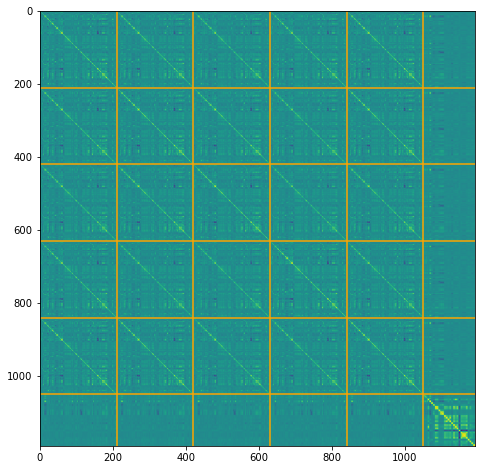

In [ ]:
feature_correlations = df_trn[df_trn[ERA]==1][X_COLS].corr()
plt.figure(figsize = (8,8))
plt.imshow(feature_correlations)
for a in [210, 420, 630, 840, 1050]:
    plt.axvline(a, color='orange')
    plt.axhline(a, color='orange')

## Correlation of feature with target as a function of the era

In [ ]:
def corrs_with_target(era):
    return np.corrcoef(df_trn[df_trn[ERA]==era][[Y_TRUE] + X_COLS].T)[0, 1:]

eras = df_trn[ERA].unique()
t_corrs = np.array([corrs_with_target(era) for era in eras])
t_corrs = pd.DataFrame(t_corrs)
t_corrs.rename(columns = dict(enumerate(X_COLS)), inplace=True)
t_corrs.insert(0, ERA, eras)

Text(0, 0.5, 'correlation with target')

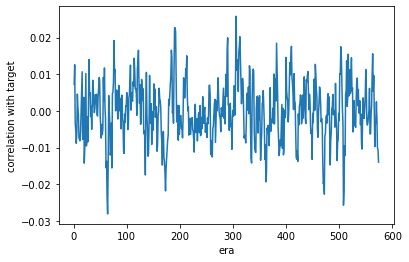

In [ ]:
x = t_corrs[ERA]
y = t_corrs['feature_untidy_withdrawn_bargeman']

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel(ERA)
ax.set_ylabel('correlation with target')

# Notes for testing models

Performance metrics:

- correlation
- rank-correlation / spearman-correlation
- `sklearn.metrics.r2_score`
- `sklearn.metrics.mean_squared_error`

Models worth trying at first

- `sklearn.linear_model.LinearRegression()`
- `sklearn.linear_model.LogisticRegression()` (This doesn't work, it's only for classification - but some example uses it?)
- `sklearn.linear_model.SGDRegressor()` (Stochastic Gradient Descent regressor)
- `sklearn.linear_model.Lasso()`
- `sklearn.linear_model.ElasticNet()`
- `sklearn.linear_model.Ridge()`
- `sklearn.svm.SVR(kernel='rbf')` (Support Vector Machine / Regression)
- `sklearn.svm.SVR(kernel='linear')`
- `lightgbm.LGBMRegressor()`
- `xgboost.XGBRegressor()`

Ensembles

- `sklearn.ensemble.RandomForestRegressor()`
- `sklearn.ensemble.ExtraTreesRegressor()`
- `sklearn.ensemble.BaggingRegressor()`
- `sklearn.ensemble.AdaBoostRegressor()`
- `sklearn.ensemble.GradientBoostingRegressor()`